## Take a bunch of runs and re-do them with 

In [1]:
from matplotlib import rc
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
import xrft
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
import shutil
os.chdir("/home/149/ab8992/bottom_near_inertial_waves/automate_experiments")

import autolib as al
from dask.distributed import Client
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41105 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41105/status,
Dashboard: /proxy/41105/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44039,Workers: 7
Dashboard: /proxy/41105/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:39785,Total threads: 4
Dashboard: /proxy/39235/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:40627,


# Notebook to process the outputs of interfacial filtered

Here we have a bunch of outputs saved, produced via:

$\huge PE = \rho \sum g' e^2 $ \
$\huge \alpha = \frac{\omega^2 + f^2}{\omega^2 - f^2} $ \
$\huge \hat{E} = \frac{1}{T} \rho\hat{PE} (1 + \alpha) $

Integrating $\hat{E}$ then gives total wave energy as a wave energy. 

The saved files include the positive quarter of $\hat{PE}$, integrated $\hat{E}$ and integrated $\hat{PE}$

In [2]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist

## Perterbation values
## strat variables 
strats = [0.001,0.01,0.2,0.25,0.5,0.75,1,1.25,1.5,2]

## Height
heights = [10,20,50,80,120,150,225,275,350,450,500,600,650,700,750]
           
# ,1000,1250,1500,2000]

## Duration
durations = [0.5,1,2,3,4,5,6,7,8,8.7,10,12,14,15,16,20] 

## Strength
strengths = [0.1,0.2,0.5,0.75,1,1.25,1.5,2,3,4,5,6,7,8,9,10]

## Topog Width
widths = [4,8,12.5,16,25,35,50,75,100,125,150,200,300,400,500,600,700,800,1000] 



# ## Forcing Width
# forcing_widths = [25,50,75,100,150,175,200,250,300,400,500,800,1000]

# ## Height
# heights = [10,20,50,80,120,150,225,275,350,450,600]

# ## Duration
# durations = [0.5,1,2,3,4,5,6,8.7,10] ## Note! Will need to modify the amount of time that model runs for with forcing in this case

# ## Strength
# strengths = [0.1,0.2,0.5,0.75,1,1.25,1.5,2,3,4,10]

# ## Topog Width
# widths = [4,8,12.5,16,25,35,50,100,200] 

# ## Forcing Width
forcing_widths = [25,50,75,100,150,175,200,250,300,400,500,800,1000]


# strats = [0.001,0.01,0.2,0.25,0.5,0.75,1,1.5,2]




def openexpt(pert,values,topo,layers = 2,merid = False):
    axes = {
        "Etot":[],
        "PEtot":[],
        "windw":[],
        "xax":[]
    }
    for i in values:
        try:
            if merid == False:
                energies = xr.open_dataset(f"/g/data/v45/ab8992/bottom_iwbs/spectral/decomp/june_{pert}_{topo}_{layers}layer_{pert}-{i}")
                ww = xr.open_dataset(f"/g/data/v45/ab8992/bottom_iwbs/spectral/windwork/june_{pert}_{topo}_{layers}layer_{pert}-{i}").ww_tot

            else:
                energies = xr.open_dataset(f"/g/data/v45/ab8992/bottom_iwbs/spectral/merid/decomp/june_{pert}_{topo}_{layers}layer_{pert}-{i}")
                ww = xr.open_dataset(f"/g/data/v45/ab8992/bottom_iwbs/spectral/merid/windwork/june_{pert}_{topo}_{layers}layer_{pert}-{i}").ww_tot

        except:
            print(f"Trouble opening {pert} {i}" )



        axes["Etot"].append(energies.Etot.sum("zi")/4000) ## I'd previously multiplied by depth. This is wrong
        axes["PEtot"].append(energies.PEtot.sum("zi")/4000)
        axes["xax"].append(i)
        axes["windw"].append(ww.values)
        ww.close()
        energies.close()
    for i in axes:
        axes[i] = np.array(axes[i])



    return axes

import matplotlib
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 12}
matplotlib.rc('font', **font)

def plotexpt(name,pert,xlabel,xlim = None,ylim = None,scale_windwork = 50 / 2000,merid = False):


    fig = plt.figure(figsize = (10,10))

    ax = host_subplot(111)

    fig.add_axes(ax)

    toplotr = openexpt(name,pert,"ridge",layers = 5,merid=merid)

    # toploth = openexpt(name,pert,"hill",layers = 5)

    ax.plot(toplotr["xax"],toplotr["Etot"]/1e3,marker = "o",label = "Total energy",color = "orange")
    ax.plot(toplotr["xax"],toplotr["PEtot"]/1e3,marker = "o",label = "Potential energy",color = "blue")

    # plt.scatter(toploth["xax"],toploth["Etot"]/1e3,marker = "x",label = "E Hill")
    # plt.scatter(toploth["xax"],toploth["PEtot"]/1e3,marker = "x",label = "PE Hill")

    ax.set_title("Time averaged wave energy in domain")
    ax.set_ylabel("KJ")
    ax.set_xlabel(xlabel)
    ax2 = ax.twinx()

    if name == "width":
        scale_windwork = 4 * toplotr["xax"] / 2000
    ax2.plot(toplotr["xax"],100 * toplotr["Etot"]/( scale_windwork * toplotr["windw"]),label = "Energy Convsrsion",color = "black",marker = "x")

    ax.set_ylim(0,None)
    ax2.set_ylabel("Conversion rate (%)")
    ax.legend()






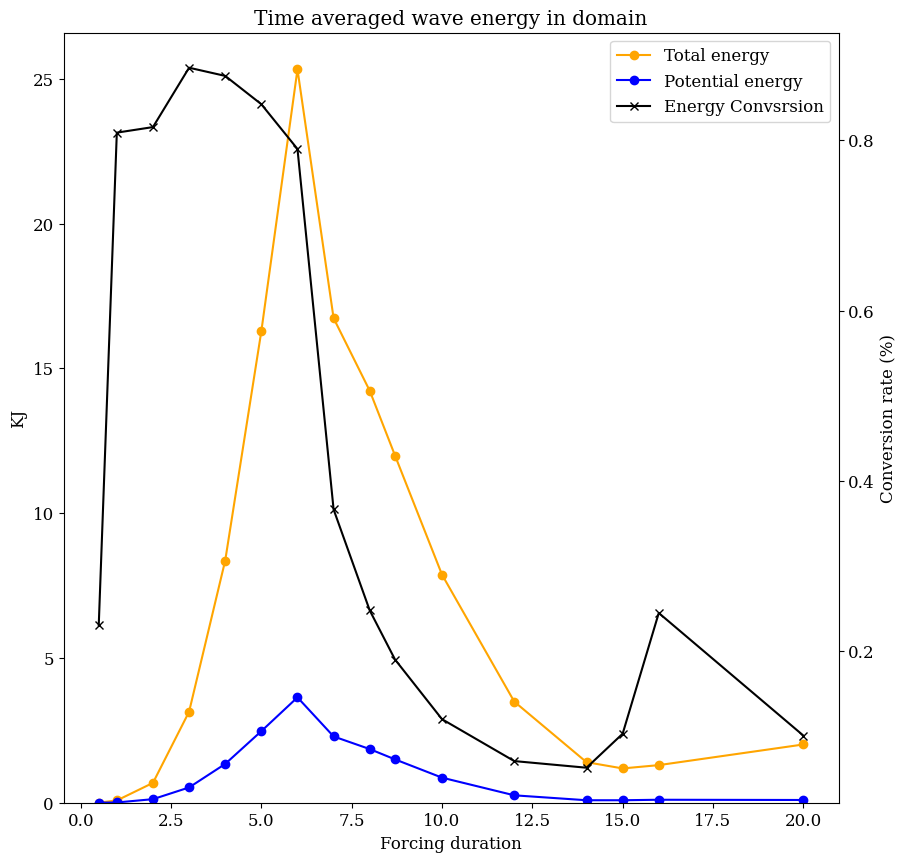

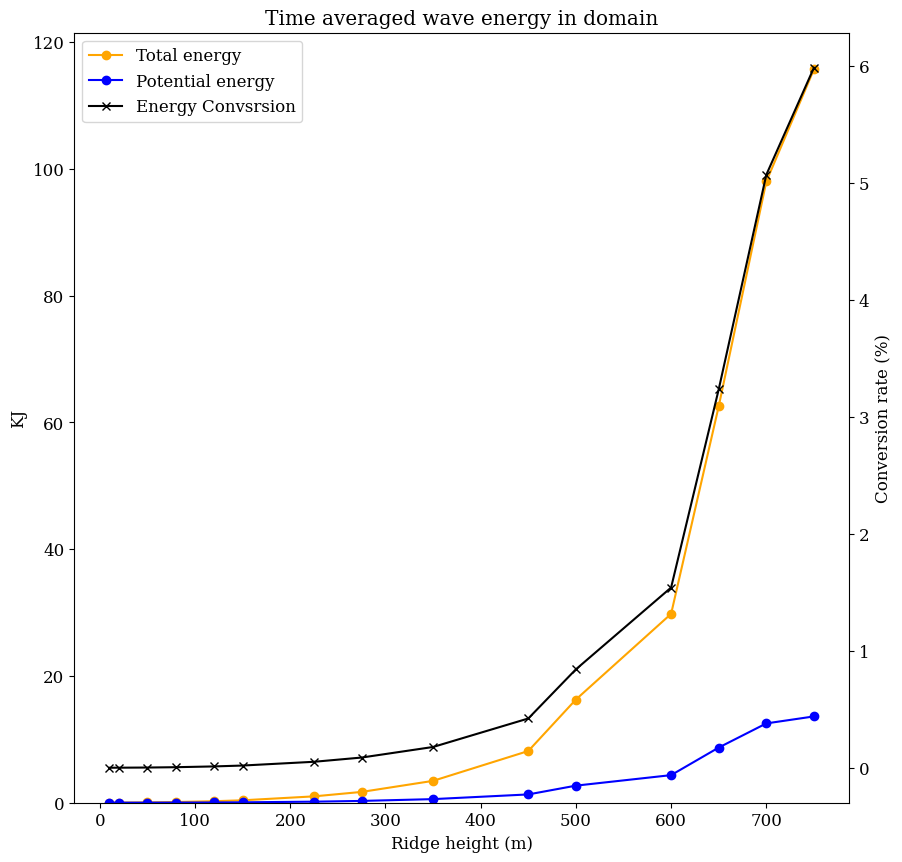

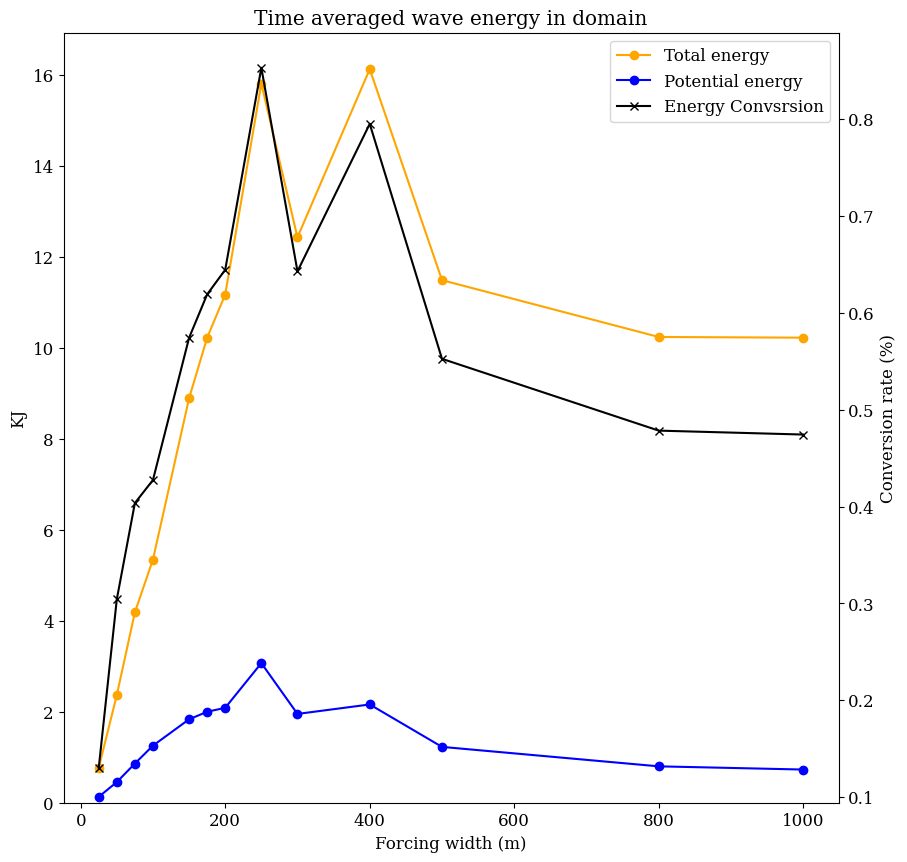

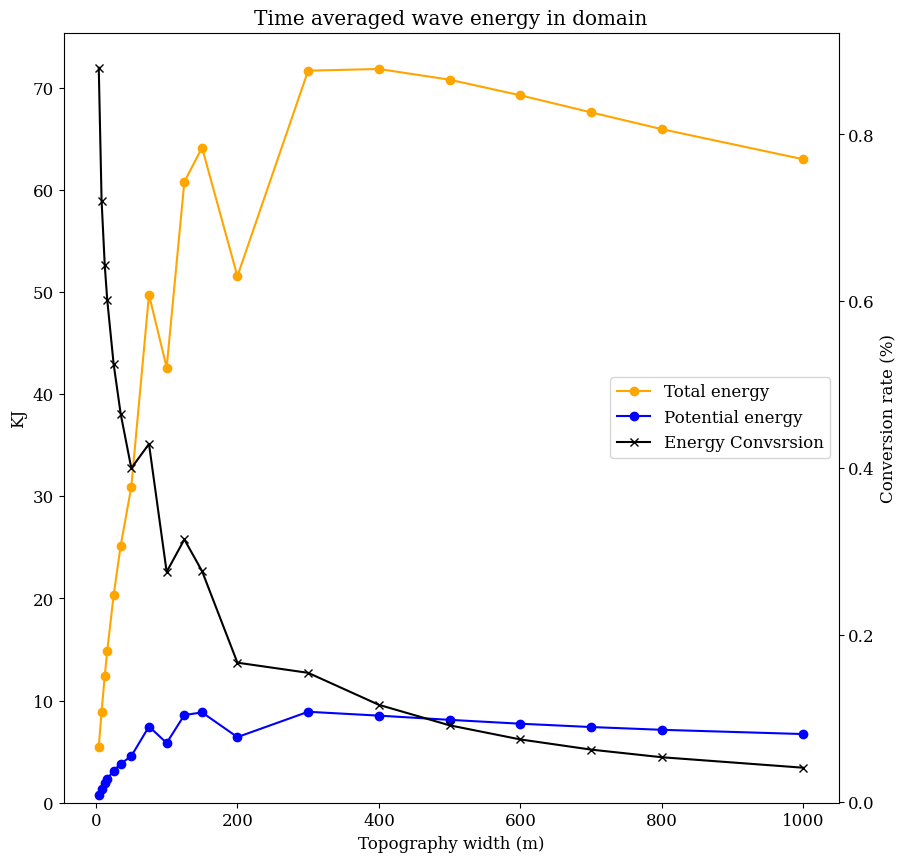

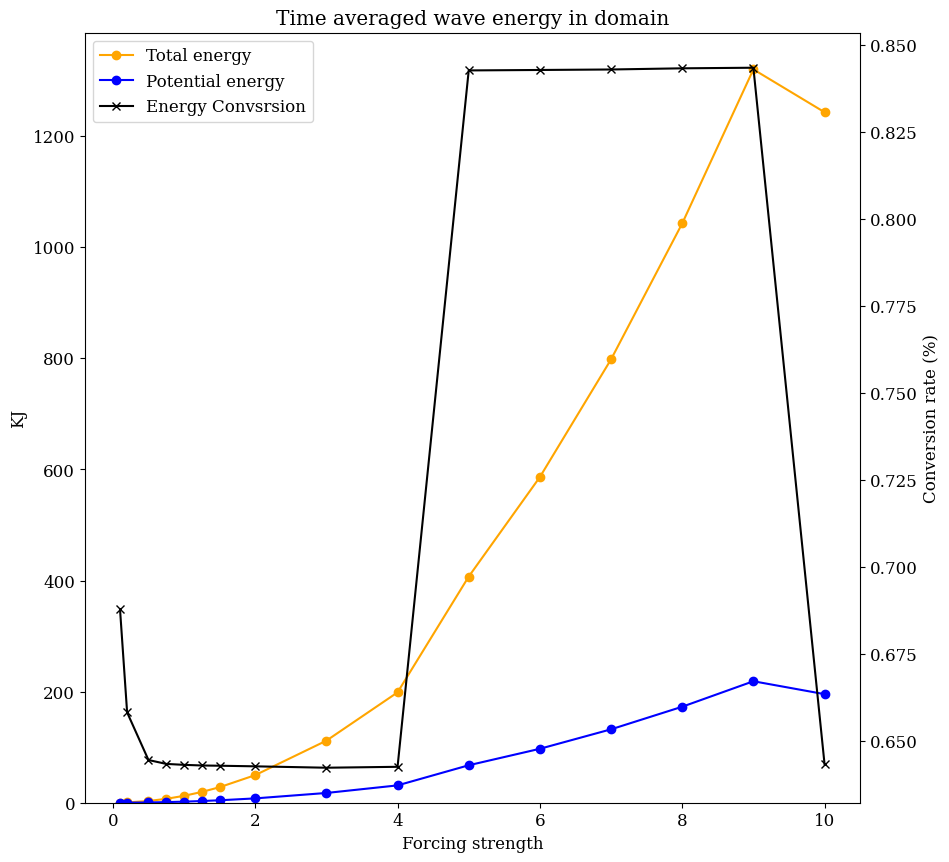

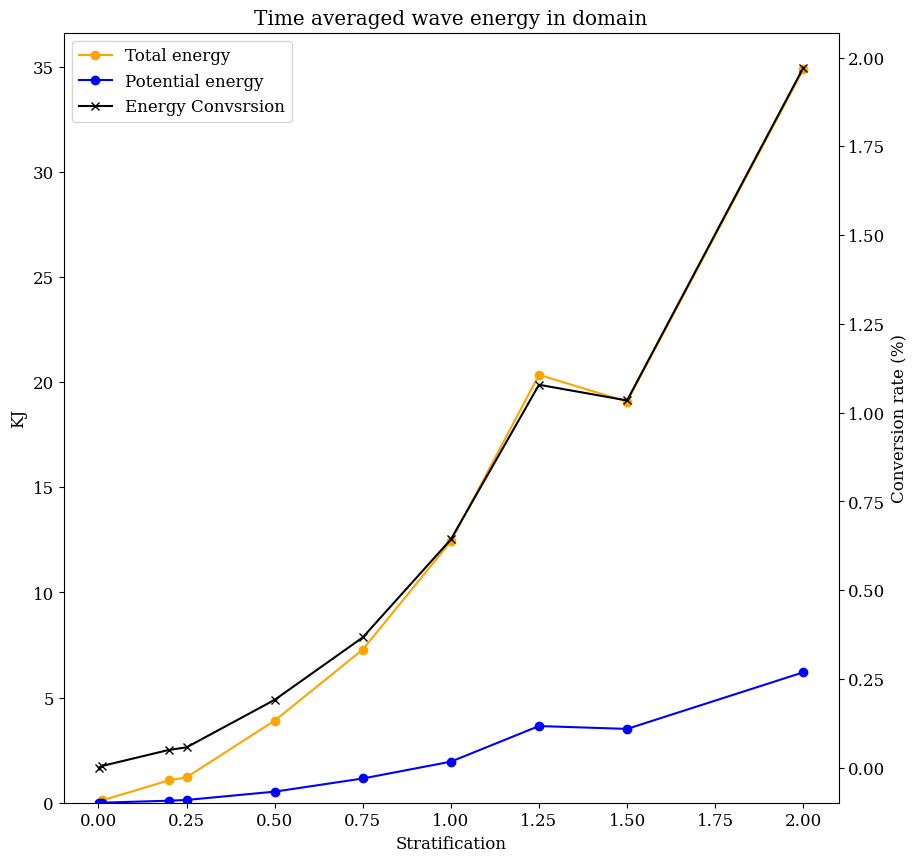

In [3]:
plotexpt("duration",durations,"Forcing duration")
plotexpt("height",heights,"Ridge height (m)")
plotexpt("forcing_latwidth",forcing_widths,"Forcing width (m)")
plotexpt("width",widths,"Topography width (m)")
plotexpt("strength",strengths,"Forcing strength")
plotexpt("strat",strats,"Stratification")

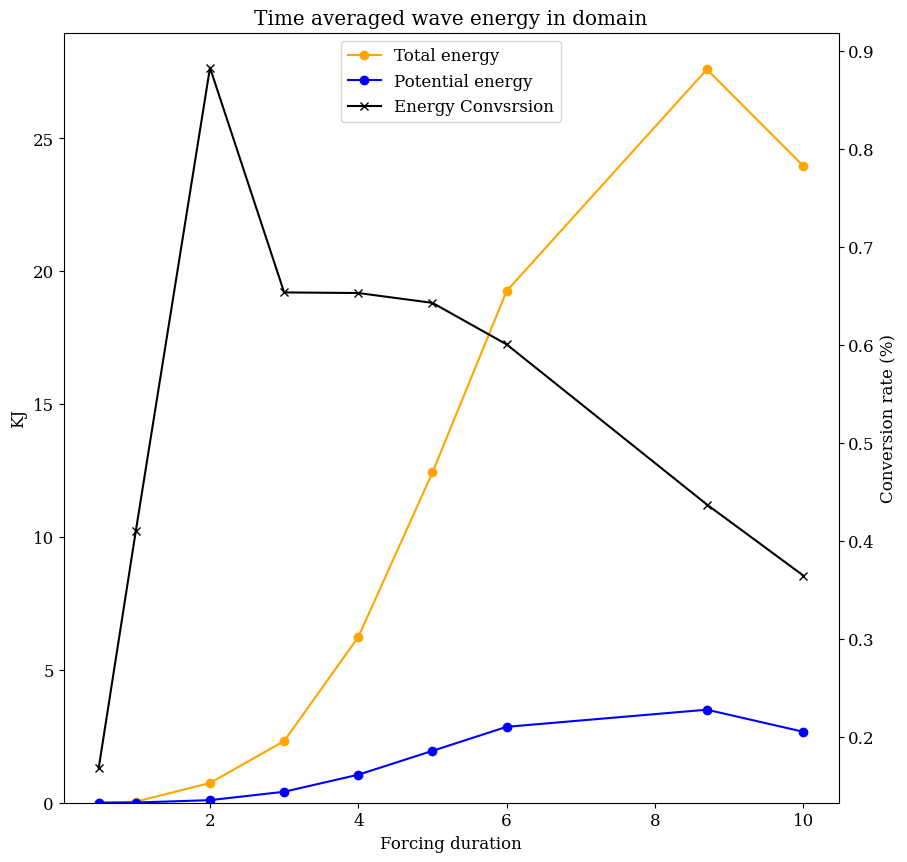

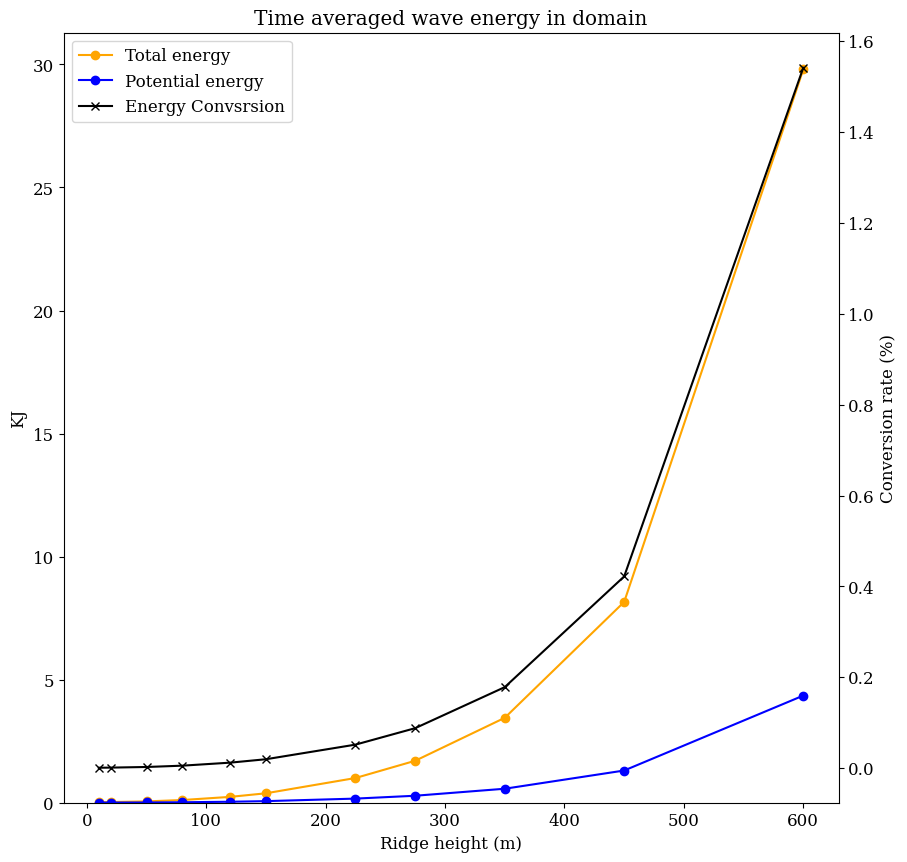

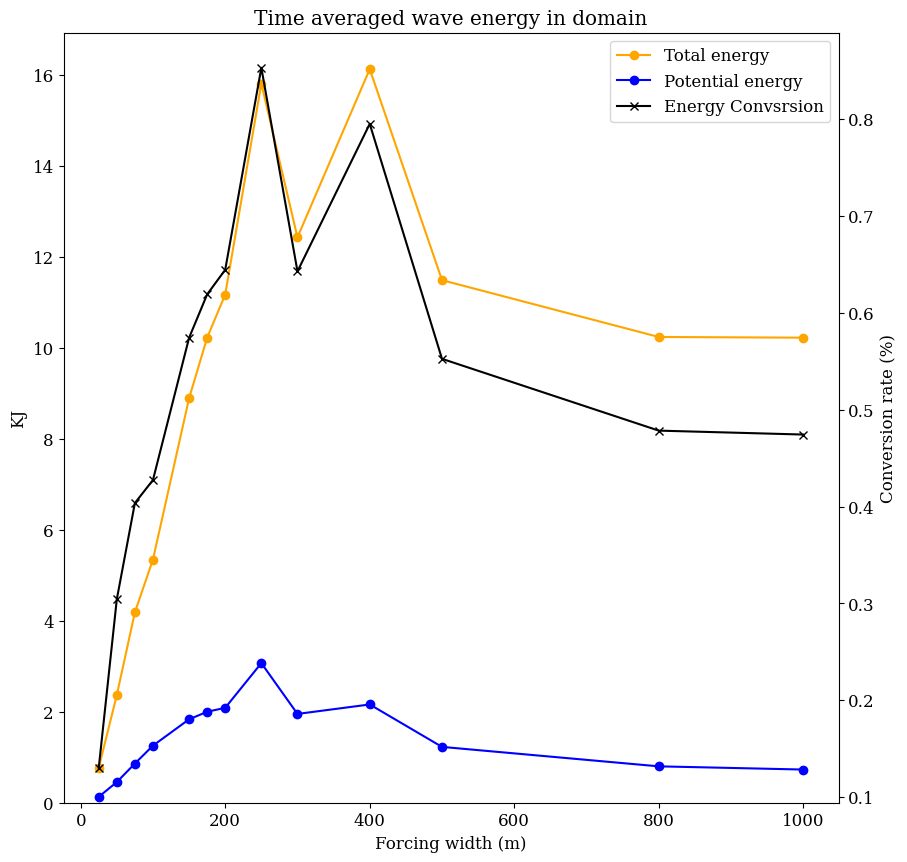

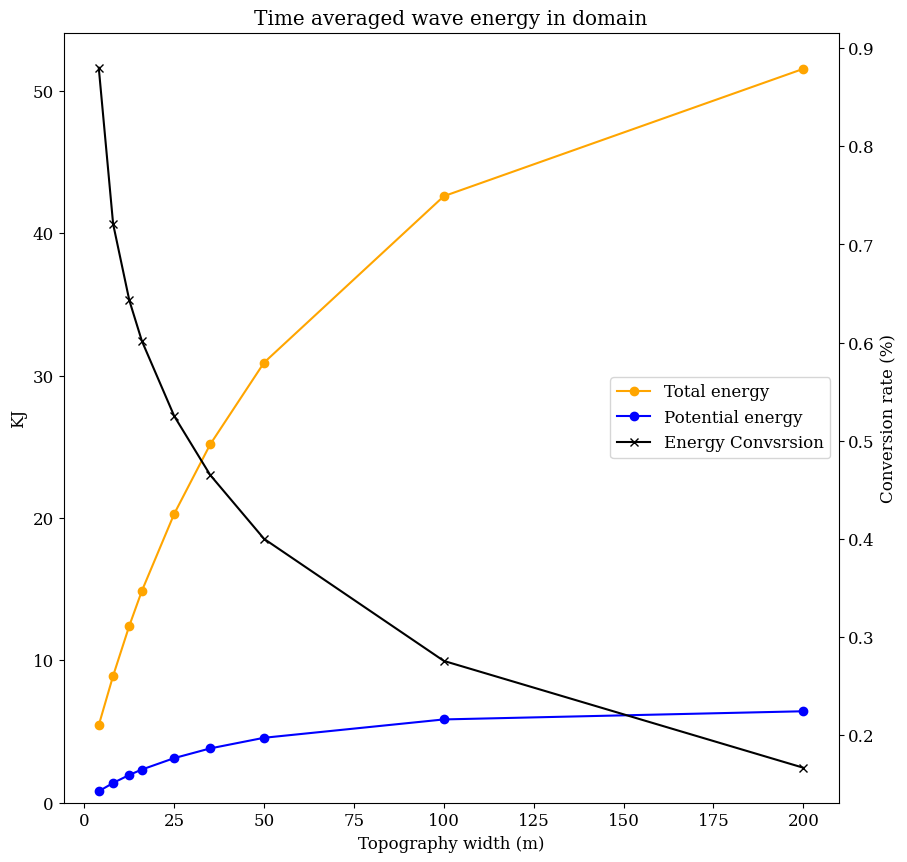

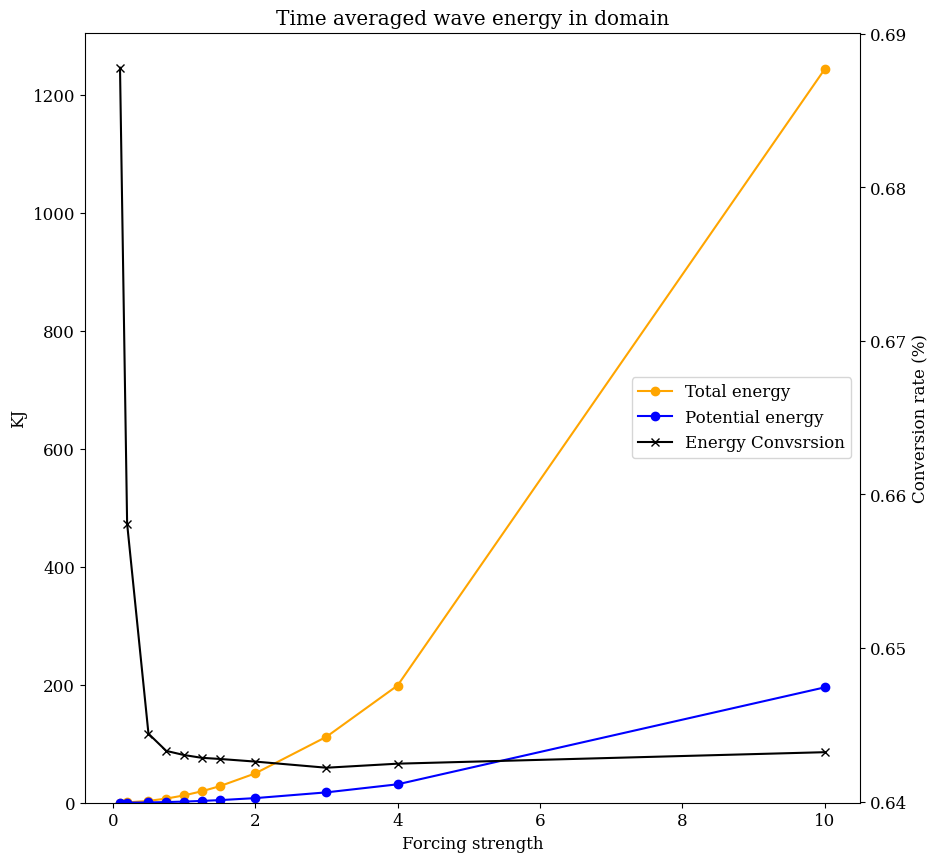

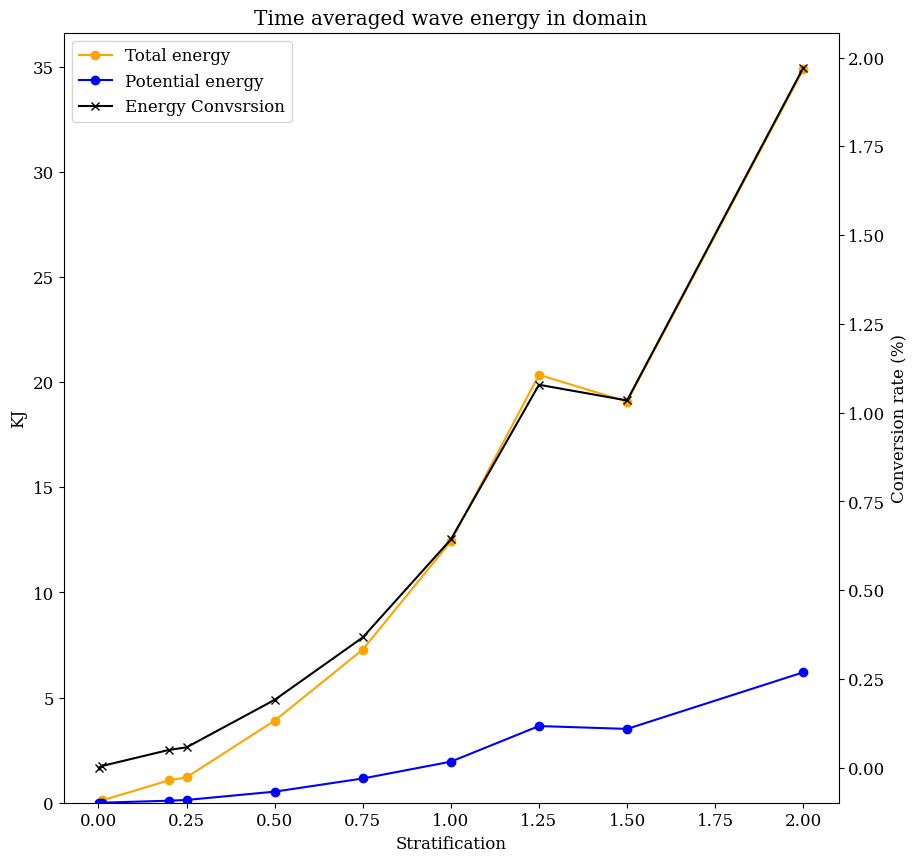

In [8]:
# ## Forcing Width
forcing_widths = [25,50,75,100,150,175,200,250,300,400,500,800,1000]

## Height
heights = [10,20,50,80,120,150,225,275,350,450,600]

## Duration
durations = [0.5,1,2,3,4,5,6,8.7,10] ## Note! Will need to modify the amount of time that model runs for with forcing in this case

## Strength
strengths = [0.1,0.2,0.5,0.75,1,1.25,1.5,2,3,4,10]

## Topog Width
widths = [4,8,12.5,16,25,35,50,100,200] 

plotexpt("duration",durations,"Forcing duration")
plotexpt("height",heights,"Ridge height (m)")
plotexpt("forcing_latwidth",forcing_widths,"Forcing width (m)")
plotexpt("width",widths,"Topography width (m)")
plotexpt("strength",strengths,"Forcing strength")
plotexpt("strat",strats,"Stratification")

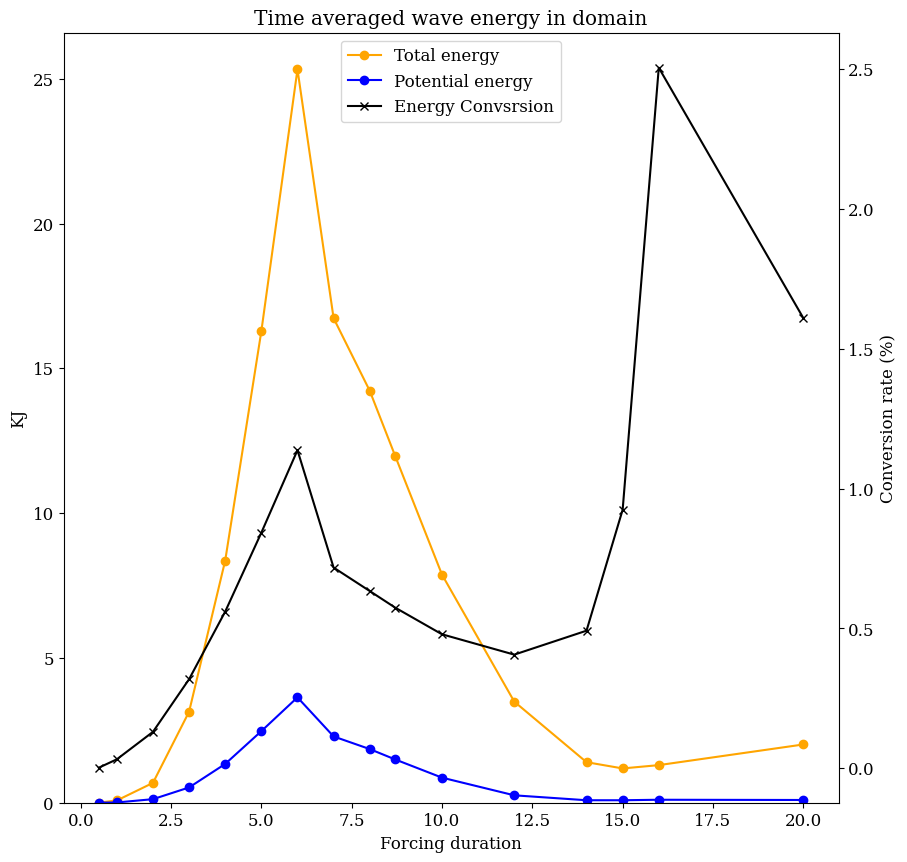

In [4]:
# plotexpt("duration",durations,"Forcing duration",merid=True)
plotexpt("duration",durations,"Forcing duration",merid=False)


(0.0, 0.00015)

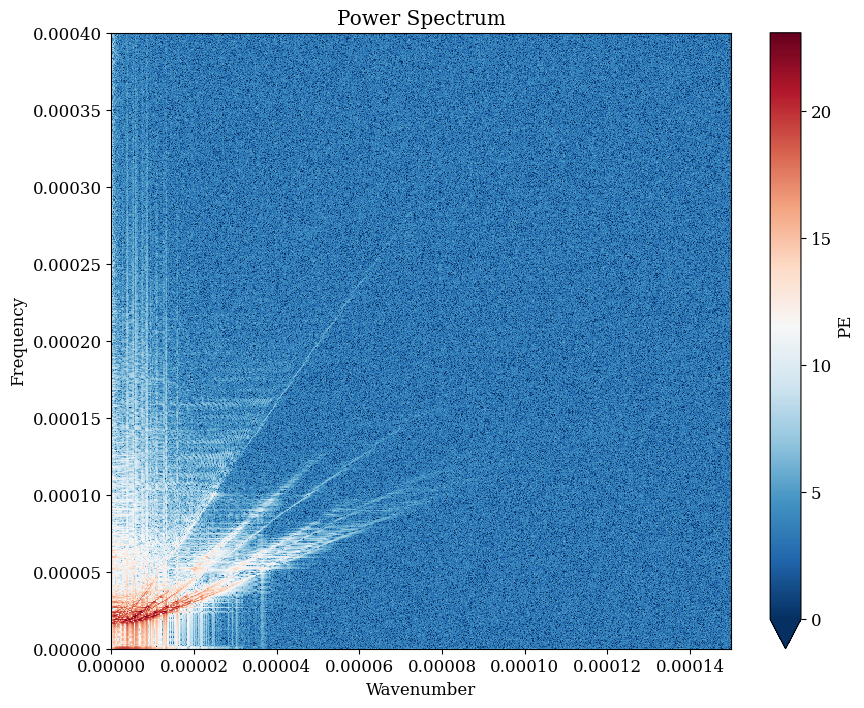

In [18]:
pert,topo,layers,i = "height","ridge",5,450

out = xr.open_dataset(f"/g/data/v45/ab8992/bottom_iwbs/spectral/decomp/june_{pert}_{topo}_{layers}layer_{pert}-{i}")

raw = xr.open_dataset(f"/g/data/v45/ab8992/bottom_iwbs/spectral/raw/june_{pert}_{topo}_{layers}layer_{pert}-{i}")

fig,ax = plt.subplots(1,figsize = (10,8))

np.log(out.PE[:,1,:]).plot(vmin = 0,ax = ax,cmap = "RdBu_r")


ax.set_ylabel("Frequency")
ax.set_xlabel("Wavenumber")
ax.set_title("Power Spectrum")
ax.set_ylim((0,0.0004))
ax.set_xlim((0,0.00015))


# plt.figure()
# raw.e.isel(zi = 1).plot()
# plt.ylabel("Frequency")
# plt.xlabel("Wavenumber")
# plt.title("Power Spectrum")
# plt.ylim((0,0.0004))
# plt.xlim((0,0.00015))

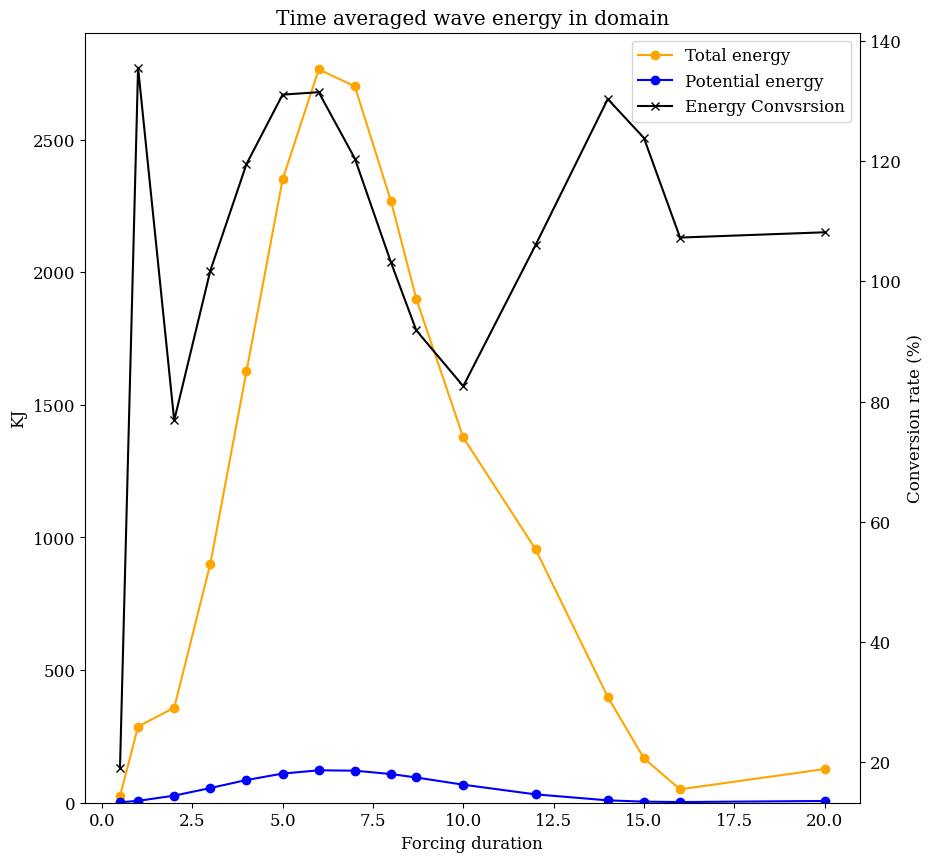

In [7]:
def plotexpt(name,pert,xlabel,xlim = None,ylim = None,scale_windwork = 50 / 2000,merid = False):


    fig = plt.figure(figsize = (10,10))

    ax = host_subplot(111)

    fig.add_axes(ax)

    toplotr = openexpt(name,pert,"ridge",layers = 5,merid=merid)

    # toploth = openexpt(name,pert,"hill",layers = 5)

    ax.plot(toplotr["xax"],toplotr["Etot"]/1e3,marker = "o",label = "Total energy",color = "orange")
    ax.plot(toplotr["xax"],toplotr["PEtot"]/1e3,marker = "o",label = "Potential energy",color = "blue")

    # plt.scatter(toploth["xax"],toploth["Etot"]/1e3,marker = "x",label = "E Hill")
    # plt.scatter(toploth["xax"],toploth["PEtot"]/1e3,marker = "x",label = "PE Hill")

    ax.set_title("Time averaged wave energy in domain")
    ax.set_ylabel("KJ")
    ax.set_xlabel(xlabel)
    ax2 = ax.twinx()

    if name == "width":
        scale_windwork = 4 * toplotr["xax"] / 2000
    ax2.plot(toplotr["xax"],100 * toplotr["Etot"]/( scale_windwork * toplotr["windw"]),label = "Energy Convsrsion",color = "black",marker = "x")

    ax.set_ylim(0,None)
    ax2.set_ylabel("Conversion rate (%)")
    ax.legend()

def openexpt(pert,values,topo,layers = 2,merid = False):
    axes = {
        "Etot":[],
        "PEtot":[],
        "windw":[],
        "xax":[]
    }
    for i in values:
        try:
            if merid == False:
                energies = xr.open_dataset(f"/g/data/v45/ab8992/bottom_iwbs/spectral/decomp/june_{pert}_{topo}_{layers}layer_{pert}-{i}")
                ww = xr.open_dataset(f"/g/data/v45/ab8992/bottom_iwbs/spectral/windwork/june_{pert}_{topo}_{layers}layer_{pert}-{i}").ww_tot

            else:
                energies = xr.open_dataset(f"/g/data/v45/ab8992/bottom_iwbs/spectral/merid/decomp/june_{pert}_{topo}_{layers}layer_{pert}-{i}")
                ww = xr.open_dataset(f"/g/data/v45/ab8992/bottom_iwbs/spectral/merid/windwork/june_{pert}_{topo}_{layers}layer_{pert}-{i}").ww_tot

        except:
            print(f"Trouble opening {pert} {i}" )



        axes["Etot"].append(energies.Etot.sum("zi")/4000) ## I'd previously multiplied by depth. This is wrong
        axes["PEtot"].append(energies.PEtot.sum("zi")/4000)
        axes["xax"].append(i)
        axes["windw"].append(ww.values)
        ww.close()
        energies.close()
    for i in axes:
        axes[i] = np.array(axes[i])



    return axes

plotexpt("duration",durations,"Forcing duration",merid=True,scale_windwork=1)
